In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, r2_score, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, classification_report, RocCurveDisplay, silhouette_score
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import xgboost as xgb
import lzma

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import sys

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

import os

from numpy import sqrt

from os.path import isfile

import pickle

import time

import matplotlib.pyplot as plt

import seaborn as sns

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.exceptions import UndefinedMetricWarning

def warn(*args, **kwargs):
    pass

import warnings

from warnings import simplefilter
simplefilter(action='ignore', category=UserWarning)

pd.set_option('float_format', '{:.4f}'.format)

import missingno as msno

## **Импорт, анализ и обработка данных**

**Сбор общих вседений**

In [2]:
transactions_df = pd.read_csv(filepath_or_buffer='./data/trans_small.csv')
identity_df = pd.read_csv(filepath_or_buffer='./data/identity_small.csv')

In [3]:
transactions_df.drop_duplicates(inplace=True)
transactions_df = transactions_df.loc[:, ~transactions_df.columns.duplicated()]

identity_df.drop_duplicates(inplace=True)
identity_df = identity_df.loc[:, ~identity_df.columns.duplicated()]

In [4]:
nan = pd.DataFrame(data = transactions_df.isna().sum(), columns=['Total NaN count'])
nan['Percent'] = transactions_df.isna().mean() * 100.0

nan

,Total NaN count,Percent
TransactionID,0,0.0000
D4,168922,28.6047
card1,0,0.0000
card2,8933,1.5127
card3,1565,0.2650
addr1,65706,11.1264
addr2,65706,11.1264
TransactionAmt,0,0.0000
isFraud,0,0.0000
C13,0,0.0000


In [5]:
nan = pd.DataFrame(data = identity_df.isna().sum(), columns=['Total NaN count'])
nan['Percent'] = identity_df.isna().mean() * 100.0

nan.T

,TransactionID,id_04,id_20,id_24,id_33,id_29,id_22,id_02
Total NaN count,0.0000,77909.0000,4972.0000,139486.0000,70944.0000,3255.0000,139064.0000,3361.0000
Percent,0.0000,54.0161,3.4472,96.7088,49.1871,2.2568,96.4162,2.3303


In [6]:
print("Rows count for:\n-Transaction:\t{}\n-Iidentity:\t{}".format(transactions_df.shape[0], identity_df.shape[0]))

Rows count for:
-Transaction:	590540
-Iidentity:	144233


In [7]:
transactions_df.describe().T

,count,mean,std,min,25%,50%,75%,max
TransactionID,590540.0000,3282269.5000,170474.3583,2987000.0000,3134634.7500,3282269.5000,3429904.2500,3577539.0000
D4,421618.0000,140.0024,191.0968,-122.0000,0.0000,26.0000,253.0000,869.0000
card1,590540.0000,9898.7347,4901.1702,1000.0000,6019.0000,9678.0000,14184.0000,18396.0000
card2,581607.0000,362.5555,157.7932,100.0000,214.0000,361.0000,512.0000,600.0000
card3,588975.0000,153.1949,11.3364,100.0000,150.0000,150.0000,150.0000,231.0000
addr1,524834.0000,290.7338,101.7411,100.0000,204.0000,299.0000,330.0000,540.0000
addr2,524834.0000,86.8006,2.6906,10.0000,87.0000,87.0000,87.0000,102.0000
TransactionAmt,590540.0000,135.0272,239.1625,0.2510,43.3210,68.7690,125.0000,31937.3910
isFraud,590540.0000,0.0350,0.1838,0.0000,0.0000,0.0000,0.0000,1.0000
C13,590540.0000,32.5399,129.3648,0.0000,1.0000,3.0000,12.0000,2918.0000


In [8]:
identity_df.describe().T

,count,mean,std,min,25%,50%,75%,max
TransactionID,144233.0000,3236329.3113,178849.5712,2987004.0000,3077142.0000,3198818.0000,3392923.0000,3577534.0000
id_04,66324.0000,-0.0589,0.7010,-28.0000,0.0000,0.0000,0.0000,0.0000
id_20,139261.0000,403.8827,152.1603,100.0000,256.0000,472.0000,533.0000,661.0000
id_24,4747.0000,12.8009,2.3724,11.0000,11.0000,11.0000,15.0000,26.0000
id_22,5169.0000,16.0027,6.8977,10.0000,14.0000,14.0000,14.0000,44.0000
id_02,140872.0000,174716.5847,159651.8169,1.0000,67992.0000,125800.5000,228749.0000,999595.0000


In [9]:
identity_df['isFraud'] = transactions_df.loc[
    transactions_df['TransactionID'].isin(identity_df['TransactionID'])
]['isFraud'].values

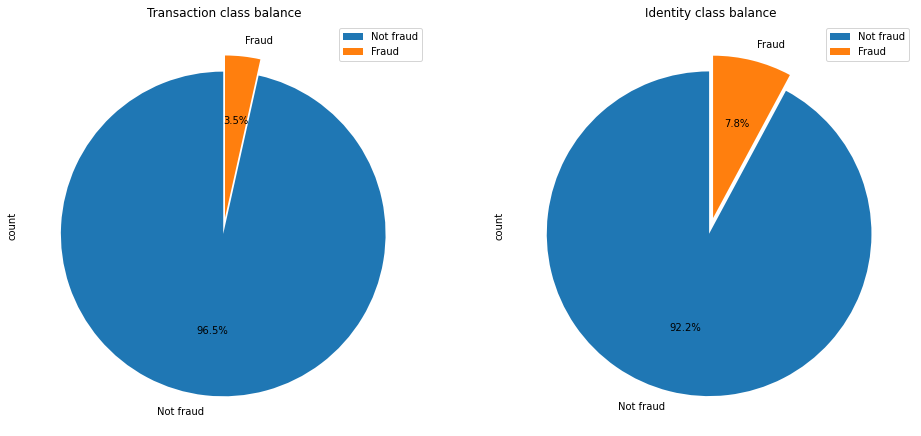

In [10]:
figure, ax = plt.subplots(1, 2, figsize=(16, 8))
axs = ax.flatten()

axs[0].set_title("Transaction class balance")
axs[1].set_title("Identity class balance")

pd.DataFrame(
    {'count': [transactions_df['isFraud'].isin([0]).sum(), transactions_df['isFraud'].isin([1]).sum(),]}, 
    index=['Not fraud','Fraud']
).plot.pie(subplots=True, figsize=(8, 8), autopct='%1.1f%%', shadow=False, startangle=90, explode=(0.05, 0.05), ax=axs[0])

pd.DataFrame(
    {'count': [identity_df['isFraud'].isin([0]).sum(), identity_df['isFraud'].isin([1]).sum(),]}, 
    index=['Not fraud','Fraud']
).plot.pie(subplots=True, figsize=(8, 8), autopct='%1.1f%%', shadow=False, startangle=90, explode=(0.05, 0.05), ax=axs[1])

plt.show()

На первый взгляд всё плохо. Огромное количество пропущенных данных. Непонятно, пропущенные данные это MCAR, MAR или MNAR. Плохой баланс. 

Очевидно, что семантику данных восстановить не получится, поскольку это данные пользователей и они както обработанны. Непонятно как.

Более того, эти два датасета являются одним датасетом, зачем-то разделенным. Причем в неравной пропорции.

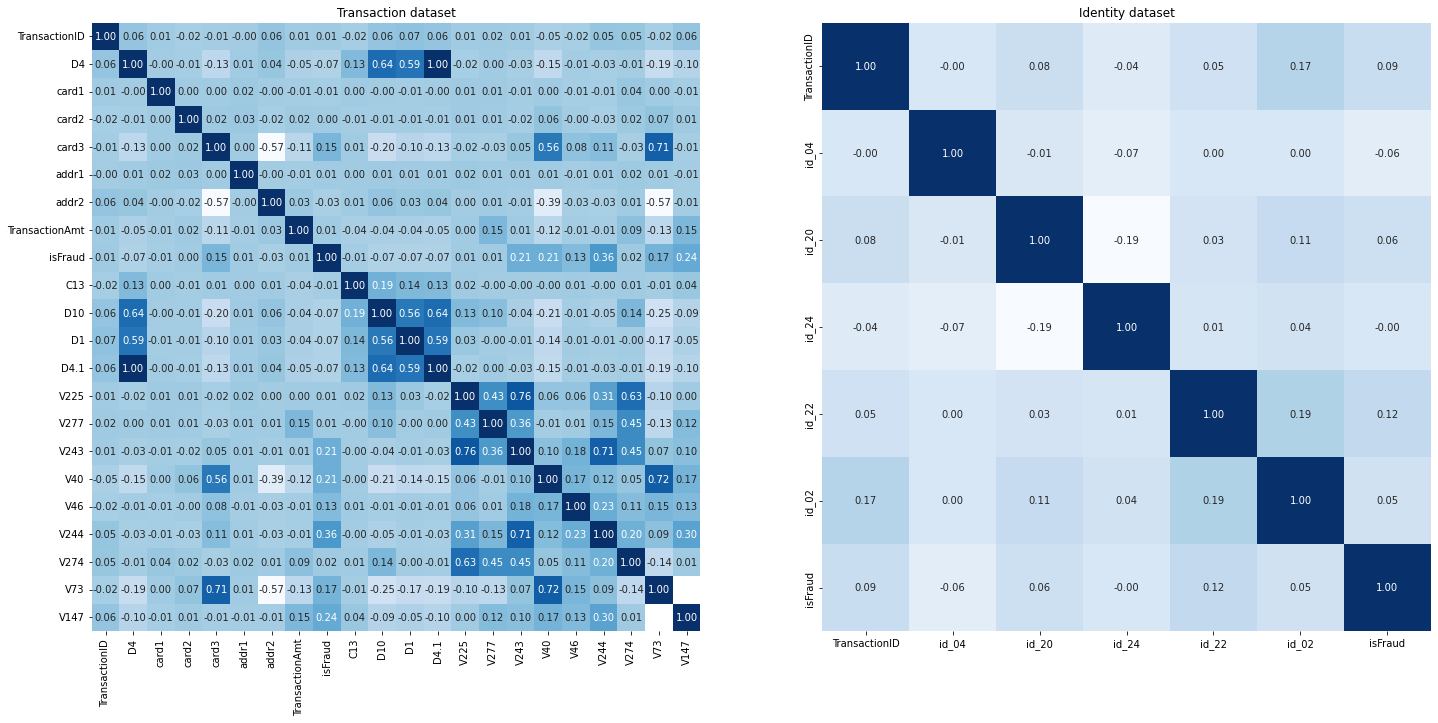

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(24,12))
axs = ax.flatten()

axs[0].set_title('Transaction dataset')
sns.heatmap(transactions_df.corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False, ax=axs[0])


axs[1].set_title('Identity dataset')
sns.heatmap(identity_df.corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False, ax=axs[1])

plt.show()

Тем не менее, данные имеют неплохую корреляцию. И даже коллениарность местами. D4 и D4.1 это одна и таже колонка, вставленная два раза. А вот корреляцию V73 и V147 вычислить вобще не удалось.

In [12]:
transactions_df.drop('D4.1', inplace=True, axis=1)

**Пропущенные значения**

Для анализа пропущенных значений я попробую использовать - <a href="https://github.com/ResidentMario/missingno">missingo</a>

Суть его проста. Он позволяет наглядно построить графики пропущенных значений и самое главное - nullity correlation (так и не понял, как перевести).

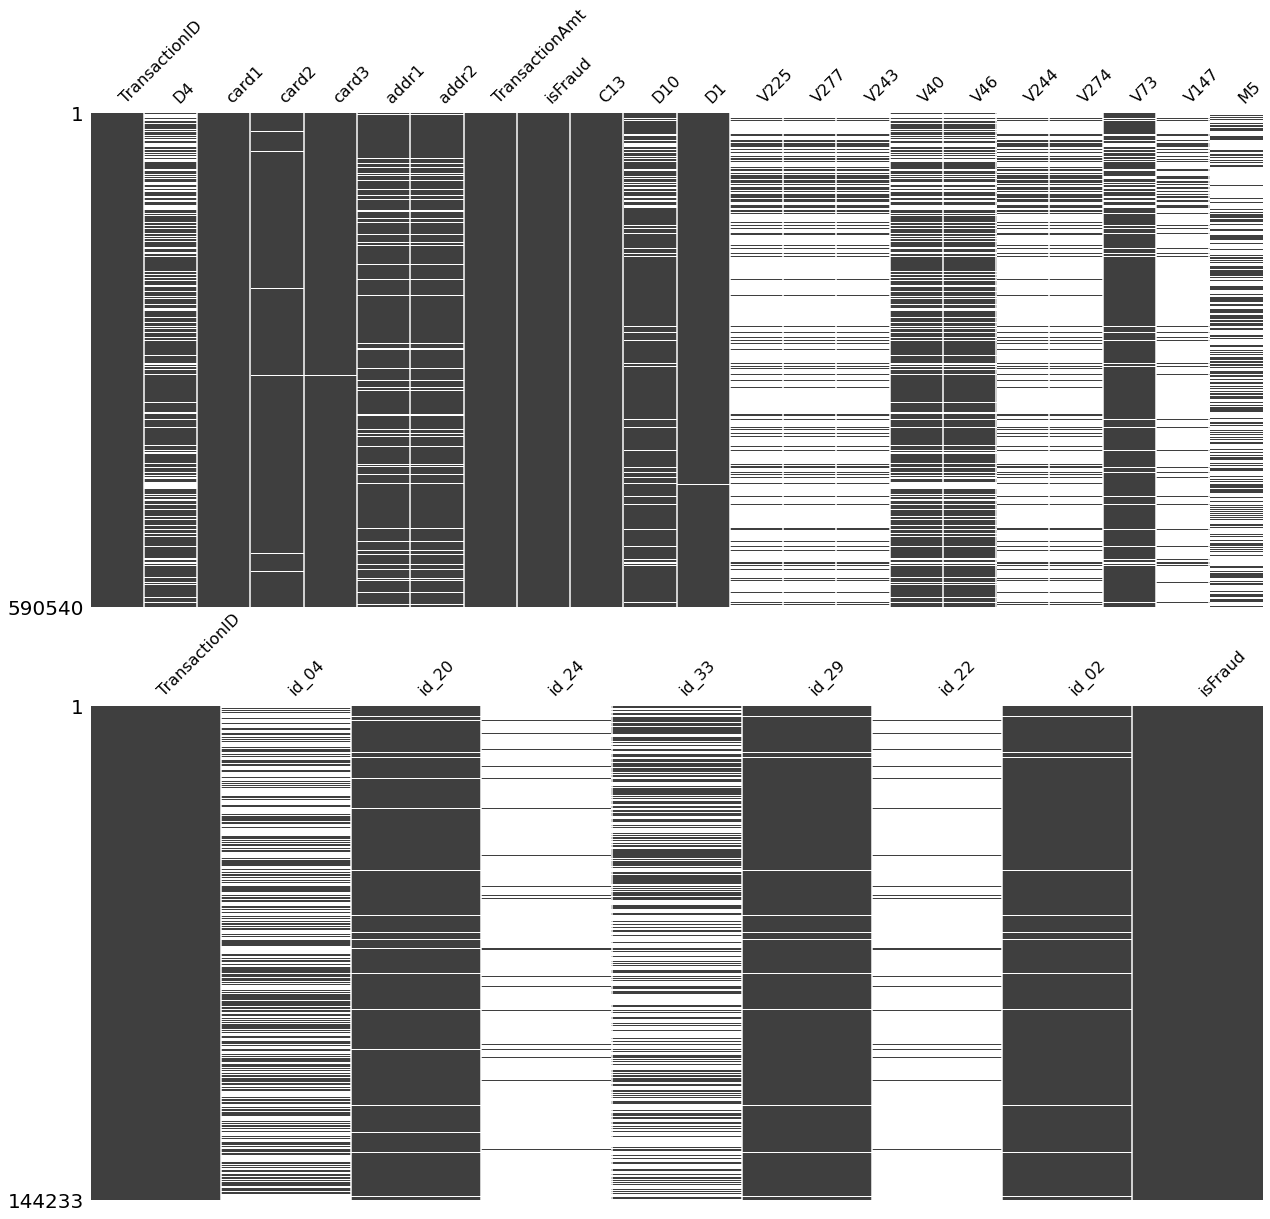

In [13]:
figure, ax = plt.subplots(2, 1, figsize=(21, 20))
axs = ax.flatten()

msno.matrix(transactions_df, ax=axs[0])
msno.matrix(identity_df, ax=axs[1])
plt.show()

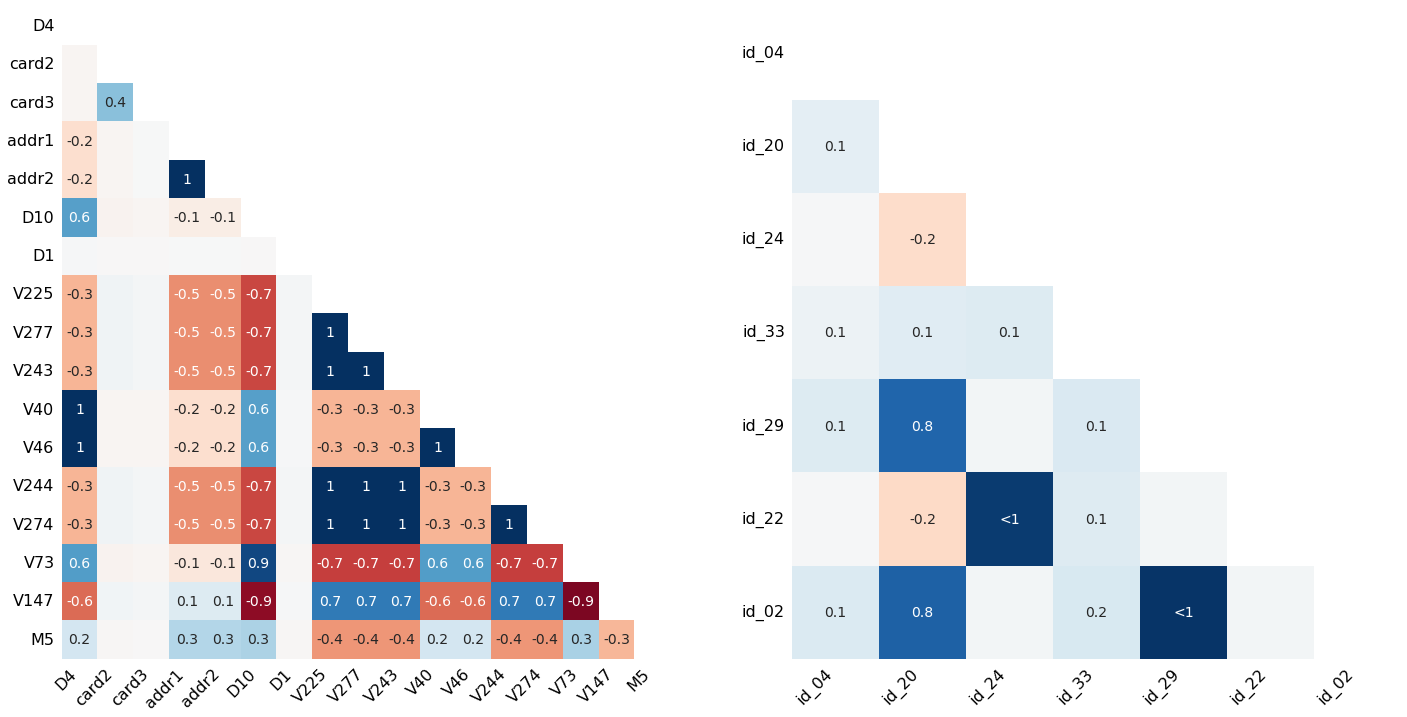

In [14]:
figure, ax = plt.subplots(1, 2, figsize=(24, 12))
axs = ax.flatten()

msno.heatmap(transactions_df, figsize=(14, 14), cbar=False, ax=axs[0])
msno.heatmap(identity_df, figsize=(14, 14), cbar=False, ax=axs[1])
plt.show()

Пояснения по поводу значений.
<br>0 - отсутствие или присутствие предиктора не влияет на отсутствие или присутствие другого предиктора. 
<br>1 - присутствие предиктора озачает точно присутствие другого. <1 тоже самое, но на основании малого количества данных.
<br>-1 - присутствие предиктора озачает точно отсутствие другого.


Что интересно, nullity corelation гораздо выше, чем корреляция значений.

Можно, конечно, обоснованно предположить, что данные просто таким образом порезали для учебного примера. Но это не по джедайски.

Получается, что для card2, card3, D1, id_04, id_33 можно применить обычные методы импутации. Для остальных предикторов я применю множественную импутацию.

В качестве алгоритма я нашел реализацию на случайном лесе - <a href="https://github.com/epsilon-machine/missingpy">missingForest</a> 

Он, по идее, не требует подготовки данных и подбора гиперпараметров, в отличии от KNN. Вычислительная стоимость у него тоже должна быть ниже. Вот и проверю.

**Размышление о NaN**

С удивлением для себя обнаружил, что NaN это не просто математическая абстракция. В pandas это numpy.NaN или любое друголе *число*. На самом деле, это может быть (и есть в R) индикатор невозможности. Например, количество беремменостей у мужчин. Это не может быть число, это невозможно. И тут я задумался. У меня нет никакой информации ни о структуре, ни о семантике предикторов. Не является ли NaN в датасете индикатором чего-то? Не является ли определенная комбинация предикторов с и без NaN признаком атаки? Поэтому я решил сохранить информацию о том, было ли значение NaN или нет.  

**Сохранение информации о NaN**

In [15]:
missing_indicator = MissingIndicator(features='all', sparse=False)

transactions_df_impute_info = missing_indicator.fit_transform(transactions_df.drop(['TransactionID', 'card1', 'TransactionAmt', 'isFraud', 'C13'], axis=1)).astype(int)
identity_df_impute_info = missing_indicator.fit_transform(identity_df.drop(['TransactionID', 'isFraud'], axis=1)).astype(int)

In [16]:
src_transactions_impute_info_df_cols = transactions_df.drop(['TransactionID', 'card1', 'TransactionAmt', 'isFraud', 'C13'], axis=1).columns.values
src_transactions_impute_info_df_cols = [x + "_nan" for x in src_transactions_impute_info_df_cols]
                                                                   
src_transactions_impute_info_df = pd.DataFrame(
    data=transactions_df_impute_info,
    columns=src_transactions_impute_info_df_cols,
)

In [17]:
src_identity_impute_info_df_cols = identity_df.drop(['TransactionID', 'isFraud'], axis=1).columns.values
src_identity_impute_info_df_cols = [x + "_nan" for x in src_identity_impute_info_df_cols]
                                                                   
src_identity_impute_info_df = pd.DataFrame(
    data=identity_df_impute_info,
    columns=src_identity_impute_info_df_cols,
)

**Импутация не связанных предикторов**

Поскольку я не люблю импутировать одним значением, применю ffill/bfill из pandas fillna. По крайней мере, это хоть как-то сохранит распределение значений.

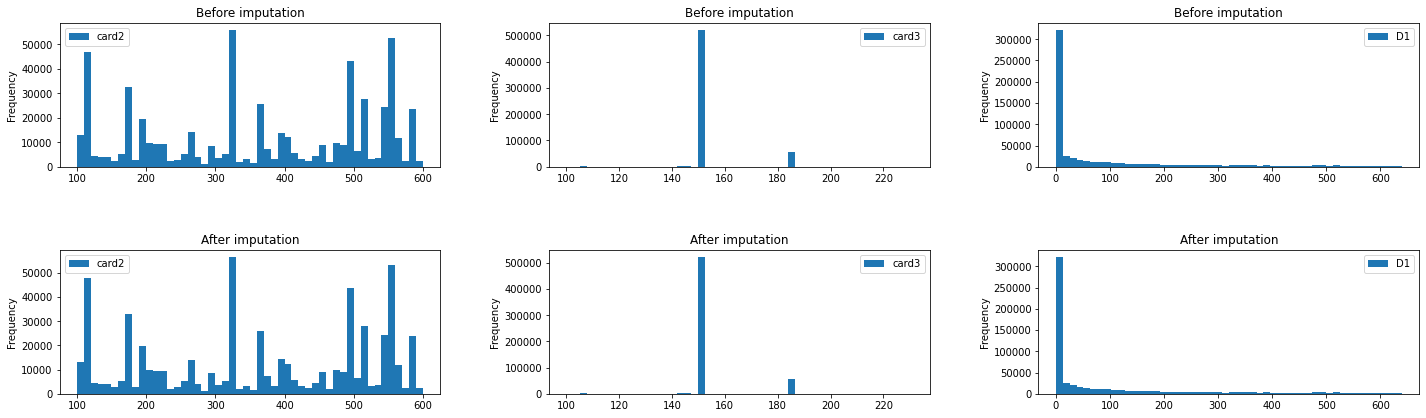

In [18]:
cols_to_impute = ['card2', 'card3', 'D1']

figure, ax = plt.subplots(2, 3, figsize=(21, 7))
axs=ax.flatten()

for idx, col in enumerate(cols_to_impute):
    transactions_df[[col]].dropna(axis=0).plot.hist(ax=axs[idx], bins=50)
    axs[idx].set_title("Before imputation")
    transactions_df[col] = transactions_df[[col]].fillna(method='ffill')
    transactions_df[col] = transactions_df[[col]].fillna(method='bfill')
    axs[idx + 3].set_title("After imputation")
    transactions_df[[col]].plot.hist(ax=axs[idx + 3], bins=50)
    
figure.tight_layout(pad=5.0)
plt.show()

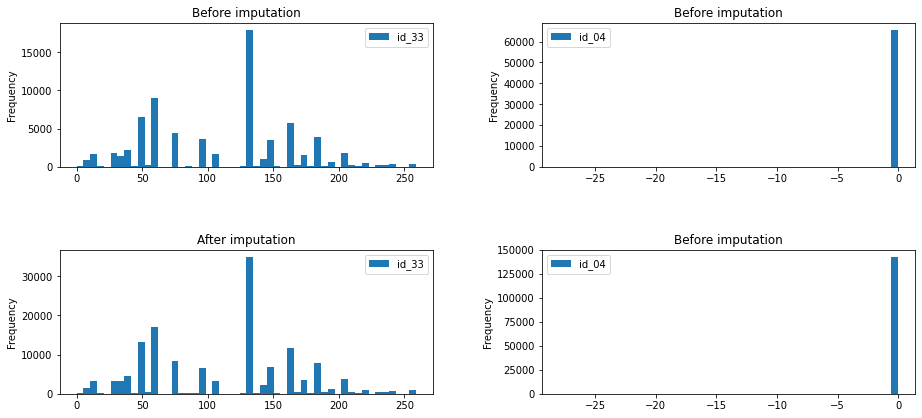

In [19]:
figure, ax = plt.subplots(2, 2, figsize=(14, 7))
axs=ax.flatten()

pd.DataFrame(
    data=LabelEncoder().fit_transform(y=identity_df[['id_33']].dropna(axis=0).to_numpy()), 
    columns=['id_33']
).plot.hist(ax=axs[0], bins=50)
axs[0].set_title("Before imputation")

identity_df['id_33'] = identity_df[['id_33']].fillna(method='ffill')
identity_df['id_33'] = identity_df[['id_33']].fillna(method='bfill')


             
identity_df['id_33'] = LabelEncoder().fit_transform(identity_df['id_33'].to_numpy())
identity_df[['id_33']].plot.hist(ax=axs[2], bins=50)
axs[2].set_title("After imputation")

identity_df[['id_04']].dropna(axis=0).plot.hist(ax=axs[1], bins=50)
axs[1].set_title("Before imputation")

identity_df['id_04'] = identity_df[['id_04']].fillna(method='ffill')
identity_df['id_04'] = identity_df[['id_04']].fillna(method='bfill')

identity_df[['id_04']].plot.hist(ax=axs[3], bins=50)
axs[3].set_title("Before imputation")

figure.tight_layout(pad=5.0)
plt.show()

**Категоризация**

Тут всего два предиктора, которые я закодирую самым простым методом - LabelEncoding.

In [20]:
m5_le = LabelEncoder()
transactions_df['M5'] = m5_le.fit_transform(y=transactions_df[['M5']].fillna('NaN'))

print(m5_le.classes_)
print(m5_le.transform(m5_le.classes_))

transactions_df['M5'] = [np.NaN if x == 1 else x for x in transactions_df['M5']]

['F' 'NaN' 'T']
[0 1 2]


In [21]:
id_29_le = LabelEncoder()
identity_df['id_29'] = id_29_le.fit_transform(y=identity_df[['id_29']].fillna('NaN'))

print(id_29_le.classes_)
print(id_29_le.transform(id_29_le.classes_))

identity_df['id_29'] = [np.NaN if x == 1 else x for x in identity_df['id_29']]

['Found' 'NaN' 'NotFound']
[0 1 2]


**Множественная импутация**

In [22]:
identity_imputed_df = pd.DataFrame()

if isfile("./data/identity_imputed_df.csv"):
    identity_imputed_df = pd.read_csv(filepath_or_buffer='./data/identity_imputed_df.csv')
else:
    imputer = MissForest(max_iter=10, random_state=42, verbose=0)
    
    df_imputed = imputer.fit_transform(identity_df.drop(['isFraud', 'TransactionID'], axis=1))
    df_imputed = pd.DataFrame(data=df_imputed, columns=identity_df.drop(['isFraud', 'TransactionID'], axis=1).columns.values)
    
    df_imputed.to_csv(path_or_buf='./data/identity_imputed_df.csv')

In [23]:
transactions_imputed_df = pd.DataFrame()

if isfile("./data/transactions_imputed_df.csv"):
    transactions_imputed_df = pd.read_csv(filepath_or_buffer='./data/transactions_imputed_df.csv')
else:
    imputer = MissForest(max_iter=10, random_state=42, verbose=0)
    
    df_imputed = imputer.fit_transform(transactions_df.drop(['isFraud', 'TransactionID'], axis=1))
    df_imputed = pd.DataFrame(data=df_imputed, columns=transactions_df.drop(['isFraud', 'TransactionID'], axis=1).columns.values)
    
    df_imputed.to_csv(path_or_buf='./data/transactions_imputed_df.csv')

**Сборка датасетов**

In [24]:
transactions_complete_df = transactions_df[['TransactionID', 'isFraud']]
transactions_complete_df = transactions_complete_df.join(transactions_imputed_df)
transactions_complete_df = transactions_complete_df.join(src_transactions_impute_info_df)
transactions_complete_df.drop(['Unnamed: 0'], axis=1, inplace=True)
transactions_complete_df.isna().sum()

TransactionID     0
isFraud           0
D4                0
card1             0
card2             0
card3             0
addr1             0
addr2             0
TransactionAmt    0
C13               0
D10               0
D1                0
V225              0
V277              0
V243              0
V40               0
V46               0
V244              0
V274              0
V73               0
V147              0
M5                0
D4_nan            0
card2_nan         0
card3_nan         0
addr1_nan         0
addr2_nan         0
D10_nan           0
D1_nan            0
V225_nan          0
V277_nan          0
V243_nan          0
V40_nan           0
V46_nan           0
V244_nan          0
V274_nan          0
V73_nan           0
V147_nan          0
M5_nan            0
dtype: int64

In [25]:
identity_complete_df = identity_df[['TransactionID']]
identity_complete_df = identity_complete_df.join(identity_imputed_df)
identity_complete_df = identity_complete_df.join(src_identity_impute_info_df)
identity_complete_df.drop(['Unnamed: 0'], axis=1, inplace=True)
identity_complete_df.isna().sum()

TransactionID    0
id_04            0
id_20            0
id_24            0
id_33            0
id_29            0
id_22            0
id_02            0
id_04_nan        0
id_20_nan        0
id_24_nan        0
id_33_nan        0
id_29_nan        0
id_22_nan        0
id_02_nan        0
dtype: int64

**Объединение датасетов**

У меня на входе две неравные части одного датасета. Никакой информации о причинах такого разделения нет. Объединять буду по TransactionID.

In [26]:
merged_df = identity_complete_df.merge(
    right = transactions_complete_df,
    on='TransactionID'
)

merged_df.to_csv(path_or_buf='./data/merged_df.csv', compression='xz')

merged_df.drop(['TransactionID'], axis=1, inplace=True)

merged_df.shape

(144233, 52)

Увеличение количества предикторов почти вдвое меня не радует. И я хотел бы сократить это количество. Но поскольку мне ничего не известно о семантике данных, пока оставлю как есть.

**Визуальный анализ**

In [27]:
nan_columns = list(merged_df.filter(regex='_nan'))
merged_no_nan_info_df = merged_df[merged_df.columns.drop(nan_columns)]

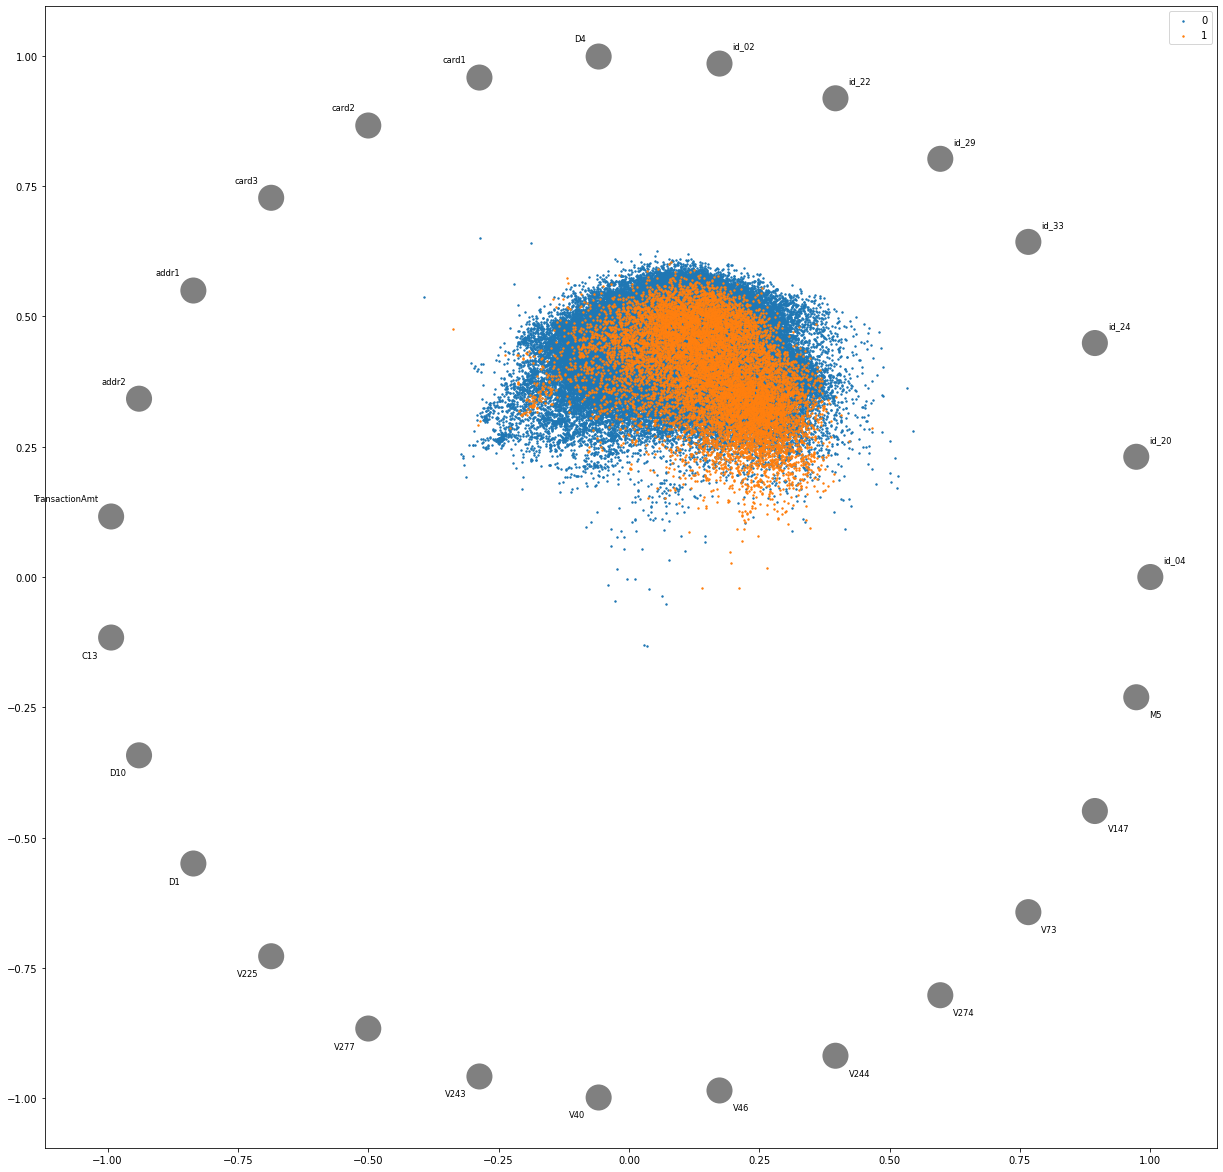

In [28]:
fig = plt.figure(figsize=(21, 21))

pd.plotting.radviz(frame=merged_no_nan_info_df, class_column='isFraud', color=sns.color_palette(), s=2)

plt.show()

Велико пересечение. Однако это проекция на двумерную плоскость. Может быть, в трех измерениях ситуауия иная.

## **Базовая модель**

Я выбрал Random Forest просто потому, что он мне нравится.

In [29]:
over_sampler = SMOTE(random_state=42, n_jobs=-1, sampling_strategy='minority')
under_sampler = RandomUnderSampler(random_state=42)

In [30]:
X_imb = merged_df.drop(['isFraud'], axis=1)
y_imb = merged_df[['isFraud']]

X_nn = merged_no_nan_info_df.drop(['isFraud'], axis=1)

X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X_imb, y_imb, test_size=0.1, shuffle=True, random_state=42, stratify=y_imb)
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_imb, test_size=0.1, shuffle=True, random_state=42, stratify=y_imb)

# Undersampling X_train, y_train
X_train_us, y_train_us = under_sampler.fit_resample(X_train_imb, y_train_imb)

# Oversampling X_train, y_train
X_train_os, y_train_os = over_sampler.fit_resample(X_train_imb, y_train_imb)

# Oversampling to 0.5 and undersampling to 0.5
X_train_ous, y_train_ous = RandomOverSampler(sampling_strategy=0.5, random_state=42).fit_resample(X_train_imb, y_train_imb)
X_train_ous, y_train_ous = RandomUnderSampler(sampling_strategy=0.5, random_state=42).fit_resample(X_train_ous, y_train_ous)

print("Size for:\n- imbalanced ds:\t{}\n- oversamppled ds:\t{}\n- undersampled ds:\t{}\n- over_undersampled:\t{}".format(X_train_imb.shape[0], X_train_os.shape[0], X_train_us.shape[0], X_train_ous.shape[0]))
print("Balance for:\n- imbalanced ds:\t0:{}\t1: {}\n- oversamppled ds:\t0: {}\t1: {}\n- undersampled ds:\t0: {}\t1: {}\n- over_undersampled:\t0: {}\t1: {}".format(
    np.unique(y_train_imb, return_counts=True)[1][0], np.unique(y_train_imb, return_counts=True)[1][1],  
    np.unique(y_train_os, return_counts=True)[1][0], np.unique(y_train_os, return_counts=True)[1][1],  
    np.unique(y_train_us, return_counts=True)[1][0], np.unique(y_train_us, return_counts=True)[1][1],  
    np.unique(y_train_ous, return_counts=True)[1][0], np.unique(y_train_ous, return_counts=True)[1][1],  
))

Size for:
- imbalanced ds:	129809
- oversamppled ds:	239246
- undersampled ds:	20372
- over_undersampled:	179433
Balance for:
- imbalanced ds:	0:119623	1: 10186
- oversamppled ds:	0: 119623	1: 119623
- undersampled ds:	0: 10186	1: 10186
- over_undersampled:	0: 119622	1: 59811


In [31]:
rf_with_nan_model = RandomForestClassifier()
rf_no_nan_model = RandomForestClassifier()

if isfile("./data/models/rf_with_nan_model.xz"):
    with lzma.open("./data/models/rf_with_nan_model.xz", "rb") as m_file:
        rf_with_nan_model = pickle.load(m_file)
else:
    rf_with_nan_model = RandomForestClassifier(random_state=42, n_estimators=250, n_jobs=-1)
    rf_with_nan_model.fit(X_train_imb, y_train_imb.to_numpy().flatten())
    
    with lzma.open("./data/models/rf_with_nan_model.xz", "wb") as m_file:
        pickle.dump(rf_with_nan_model, m_file)
        

if isfile("./data/models/rf_no_nan_model.xz"):
    with lzma.open("./data/models/rf_no_nan_model.xz", "rb") as m_file:
        rf_no_nan_model = pickle.load(m_file)
else:
    rf_no_nan_model = RandomForestClassifier(random_state=42, n_estimators=250, n_jobs=-1)
    rf_no_nan_model.fit(X_train_nn, y_train_nn.to_numpy().flatten())
    
    with lzma.open("./data/models/rf_no_nan_model.xz", "wb") as m_file:
        pickle.dump(rf_no_nan_model, m_file)

In [32]:
print("ROC-AUC without NaN info: ", roc_auc_score(y_test_nn, rf_no_nan_model.predict_proba(X_test_nn)[:, 1]))
print("Accuracy without NaN info: ", accuracy_score(y_test_nn, rf_no_nan_model.predict(X_test_nn)))
print()
print("ROC-AUC with NaN info: ", roc_auc_score(y_test_imb, rf_with_nan_model.predict_proba(X_test_imb)[:, 1]))
print("Accuracy with NaN info: ", accuracy_score(y_test_imb, rf_with_nan_model.predict(X_test_imb)))

ROC-AUC without NaN info:  0.9309498912175447
Accuracy without NaN info:  0.9558374930671104

ROC-AUC with NaN info:  0.933570825300481
Accuracy with NaN info:  0.9584719911259013


Интересно, но сохранение информации о NaN дает неплохой прирост ROC-AUC и Accuracy. Значения могут выглядить малыми (такими они и есть), но это сотни и тысяси транзакций за день и десятки часов работы специалистов.

**Undersampling**

In [33]:
rf_undersample = RandomForestClassifier()

if isfile("./data/models/rf_undersample.xz"):
    with lzma.open("./data/models/rf_undersample.xz", "rb") as m_file:
        rf_undersample = pickle.load(m_file)
else:
    rf_undersample = RandomForestClassifier(random_state=42, n_estimators=250, n_jobs=-1)
    rf_undersample.fit(X_train_us, y_train_us.to_numpy().flatten())
    
    with lzma.open("./data/models/rf_undersample.xz", "wb") as m_file:
        pickle.dump(rf_undersample, m_file)

**Oversampling**

In [34]:
rf_oversample = RandomForestClassifier()

if isfile("./data/models/rf_oversample.xz"):
    with lzma.open("./data/models/rf_oversample.xz", "rb") as m_file:
        rf_oversample = pickle.load(m_file)
else:
    rf_oversample = RandomForestClassifier(random_state=42, n_estimators=250, n_jobs=-1)
    rf_oversample.fit(X_train_os, y_train_os.to_numpy().flatten())
    
    with lzma.open("./data/models/rf_oversample.xz", "wb") as m_file:
        pickle.dump(rf_oversample, m_file)

**Oversampling and Undersampling**

In [35]:
rf_over_undersample = RandomForestClassifier()

if isfile("./data/models/rf_over_undersample.xz"):
    with lzma.open("./data/models/rf_over_undersample.xz", "rb") as m_file:
        rf_over_undersample = pickle.load(m_file)
else:
    rf_over_undersample = RandomForestClassifier(random_state=42, n_estimators=250, n_jobs=-1)
    rf_over_undersample.fit(X_train_ous, y_train_ous.to_numpy().flatten())
    
    with lzma.open("./data/models/rf_over_undersample.xz", "wb") as m_file:
        pickle.dump(rf_over_undersample, m_file)

In [36]:
print("ROC-AUC for imbalanced dataset: ", roc_auc_score(y_test_imb, rf_with_nan_model.predict_proba(X_test_imb)[:, 1]))
print("ROC-AUC for oversampled dataset: ", roc_auc_score(y_test_imb, rf_oversample.predict_proba(X_test_imb)[:, 1]))
print("ROC-AUC for undersampled dataset: ", roc_auc_score(y_test_imb, rf_undersample.predict_proba(X_test_imb)[:, 1]))
print("ROC-AUC for over and undersampled dataset: ", roc_auc_score(y_test_imb, rf_over_undersample.predict_proba(X_test_imb)[:, 1]))
print()
print("Accuracy for imbalanced dataset: ", accuracy_score(y_test_imb, rf_with_nan_model.predict(X_test_imb)))
print("Accuracy for ovdersampled dataset: ", accuracy_score(y_test_imb, rf_oversample.predict(X_test_imb)))
print("Accuracy for undersampled dataset: ", accuracy_score(y_test_imb, rf_undersample.predict(X_test_imb)))
print("Accuracy for over - undersampled dataset: ", accuracy_score(y_test_imb, rf_over_undersample.predict(X_test_imb)))

ROC-AUC for imbalanced dataset:  0.933570825300481
ROC-AUC for oversampled dataset:  0.9280420141661766
ROC-AUC for undersampled dataset:  0.9239412385993754
ROC-AUC for over and undersampled dataset:  0.9375556273919113

Accuracy for imbalanced dataset:  0.9584719911259013
Accuracy for ovdersampled dataset:  0.9581253466444815
Accuracy for undersampled dataset:  0.8686217415418747
Accuracy for undersampled dataset:  0.9588186356073212


Я не буду применять никаких техник повышения точности здесь, поскольку хотел попробовать методики балансировки классов.

## **Рабочая модель**

**KNN**

**Oversampling**

In [37]:
model_knn_oversampled = KNeighborsClassifier()

if isfile("./data/models/model_knn_oversampled.xz"):
    with lzma.open("./data/models/model_knn_oversampled.xz", "rb") as m_file:
        model_knn_oversampled = pickle.load(m_file)
else:
    model_knn_oversampled.fit(X_train_os, y_train_os)
    
    with lzma.open("./data/models/model_knn_oversampled.xz", "wb") as m_file:
        pickle.dump(model_knn_oversampled, m_file)

**Undersampling**

In [38]:
model_knn_undersampled = KNeighborsClassifier()

if isfile("./data/models/model_knn_undersampled.xz"):
    with lzma.open("./data/models/model_knn_undersampled.xz", "rb") as m_file:
        model_knn_undersampled = pickle.load(m_file)
else:
    model_knn_undersampled.fit(X_train_us, y_train_us)
    
    with lzma.open("./data/models/model_knn_undersampled.xz", "wb") as m_file:
        pickle.dump(model_knn_undersampled, m_file)

**Imbalanced**

In [39]:
model_knn = KNeighborsClassifier()

if isfile("./data/models/model_knn.xz"):
    with lzma.open("./data/models/model_knn.xz", "rb") as m_file:
        model_knn = pickle.load(m_file)
else:
    model_knn.fit(X_train_imb, y_train_imb)
    
    with lzma.open("./data/models/model_knn.xz", "wb") as m_file:
        pickle.dump(model_knn, m_file)

In [40]:
print("ROC-AUC for imbalanced dataset: ", roc_auc_score(y_test_imb, model_knn.predict_proba(X_test_imb)[:, 1]))
print("ROC-AUC for oversampled dataset: ", roc_auc_score(y_test_imb, model_knn_oversampled.predict_proba(X_test_imb)[:, 1]))
print("ROC-AUC for undersampled dataset: ", roc_auc_score(y_test_imb, model_knn_undersampled.predict_proba(X_test_imb)[:, 1]))
print()
print("Accuracy for imbalanced dataset: ", accuracy_score(y_test_imb, model_knn.predict(X_test_imb)))
print("Accuracy for ovdersampled dataset: ", accuracy_score(y_test_imb, model_knn_oversampled.predict(X_test_imb)))
print("Accuracy for undersampled dataset: ", accuracy_score(y_test_imb, model_knn_undersampled.predict(X_test_imb)))

ROC-AUC for imbalanced dataset:  0.5953373412525826
ROC-AUC for oversampled dataset:  0.6133862367331661
ROC-AUC for undersampled dataset:  0.5755365484592342

Accuracy for imbalanced dataset:  0.9190238491403216
Accuracy for ovdersampled dataset:  0.7199805879090405
Accuracy for undersampled dataset:  0.5743899057127011


**XGBoost**

**Imbalanced**

In [41]:
xgb_imb = xgb.XGBClassifier(n_estimators=250, random_state=42)

dm_train_imb = xgb.DMatrix(data=X_train_imb, label=y_train_imb)
dm_test = xgb.DMatrix(data=X_test_imb, label=y_test_imb)

if isfile("./data/models/xgb_imb.xz"):
    with lzma.open("./data/models/xgb_imb.xz", "rb") as m_file:
        xgb_imb = pickle.load(m_file)
else:
    xgb_imb = xgb.train(
        params={
            'objective': 'binary:logistic',
            'eval_metric': 'auc'
        },
        dtrain=dm_train_imb,
        evals=[(dm_train_imb, "train"), (dm_test, "validation")],
        num_boost_round=10000,
        verbose_eval=20,
        early_stopping_rounds=25
    )
    
    with lzma.open("./data/models/xgb_imb.xz", "wb") as m_file:
        pickle.dump(xgb_imb, m_file)

**Undersampling**

In [42]:
xgb_us = xgb.XGBClassifier(n_estimators=250, random_state=42)

dm_train_us = xgb.DMatrix(data=X_train_us, label=y_train_us)

if isfile("./data/models/xgb_us.xz"):
    with lzma.open("./data/models/xgb_us.xz", "rb") as m_file:
        xgb_us = pickle.load(m_file)
else:
    xgb_us = xgb.train(
        params={
            'objective': 'binary:logistic',
            'eval_metric': 'auc'
        },
        dtrain=dm_train_us,
        evals=[(dm_train_us, "train"), (dm_test, "validation")],
        num_boost_round=10000,
        verbose_eval=20,
        early_stopping_rounds=25
    )
    
    with lzma.open("./data/models/xgb_us.xz", "wb") as m_file:
        pickle.dump(xgb_us, m_file)

[0]	train-auc:0.86797	validation-auc:0.85039
[20]	train-auc:0.94028	validation-auc:0.91243
[40]	train-auc:0.95747	validation-auc:0.92335
[60]	train-auc:0.96747	validation-auc:0.92821
[80]	train-auc:0.97654	validation-auc:0.93132
[100]	train-auc:0.98239	validation-auc:0.93197
[120]	train-auc:0.98655	validation-auc:0.93240
[140]	train-auc:0.99047	validation-auc:0.93299
[160]	train-auc:0.99336	validation-auc:0.93441
[180]	train-auc:0.99521	validation-auc:0.93407
[187]	train-auc:0.99561	validation-auc:0.93429


**Oversampling**

In [43]:
xgb_os = xgb.XGBClassifier(n_estimators=250, random_state=42)

dm_train_os = xgb.DMatrix(data=X_train_os, label=y_train_os)

if isfile("./data/models/xgb_os.xz"):
    with lzma.open("./data/models/xgb_os.xz", "rb") as m_file:
        xgb_os = pickle.load(m_file)
else:
    xgb_os = xgb.train(
        params={
            'objective': 'binary:logistic',
            'eval_metric': 'auc'
        },
        dtrain=dm_train_os,
        evals=[(dm_train_os, "train"), (dm_test, "validation")],
        num_boost_round=10000,
        verbose_eval=20,
        early_stopping_rounds=25
    )
    
    with lzma.open("./data/models/xgb_os.xz", "wb") as m_file:
        pickle.dump(xgb_os, m_file)

**Oversampling and Undersampling**

In [44]:
xgb_ous = xgb.XGBClassifier(n_estimators=250, random_state=42)

dm_train_os = xgb.DMatrix(data=X_train_ous, label=y_train_ous)

if isfile("./data/models/xgb_ous.xz"):
    with lzma.open("./data/models/xgb_ous.xz", "rb") as m_file:
        xgb_ous = pickle.load(m_file)
else:
    xgb_ous = xgb.train(
        params={
            'objective': 'binary:logistic',
            'eval_metric': 'auc'
        },
        dtrain=dm_train_os,
        evals=[(dm_train_os, "train"), (dm_test, "validation")],
        num_boost_round=10000,
        verbose_eval=20,
        early_stopping_rounds=25
    )
    
    with lzma.open("./data/models/xgb_ous.xz", "wb") as m_file:
        pickle.dump(xgb_ous, m_file)

[0]	train-auc:0.86503	validation-auc:0.85410
[20]	train-auc:0.93875	validation-auc:0.92011
[40]	train-auc:0.95296	validation-auc:0.93002
[60]	train-auc:0.96285	validation-auc:0.93335
[80]	train-auc:0.97071	validation-auc:0.93633
[100]	train-auc:0.97542	validation-auc:0.93712
[120]	train-auc:0.98014	validation-auc:0.93823
[140]	train-auc:0.98433	validation-auc:0.93956
[160]	train-auc:0.98732	validation-auc:0.94128
[180]	train-auc:0.98972	validation-auc:0.94166
[200]	train-auc:0.99191	validation-auc:0.94268
[220]	train-auc:0.99358	validation-auc:0.94326
[240]	train-auc:0.99461	validation-auc:0.94339
[260]	train-auc:0.99610	validation-auc:0.94391
[277]	train-auc:0.99687	validation-auc:0.94358


In [45]:
print("ROC-AUC for imbalanced dataset: ", roc_auc_score(y_test_imb, xgb_imb.predict(dm_test)))
print("ROC-AUC for oversampled dataset: ", roc_auc_score(y_test_imb, xgb_os.predict(dm_test)))
print("ROC-AUC for undersampled dataset: ", roc_auc_score(y_test_imb, xgb_us.predict(dm_test)))
print("ROC-AUC for under-overrsampled dataset: ", roc_auc_score(y_test_imb, xgb_ous.predict(dm_test)))
print()
print("Accuracy for imbalanced dataset: ", accuracy_score(y_test_imb, [round(x) for x in xgb_imb.predict(dm_test)]))
print("Accuracy for oversampled dataset: ", accuracy_score(y_test_imb, [round(x) for x in xgb_os.predict(dm_test)]))
print("Accuracy for undersampled dataset: ", accuracy_score(y_test_imb, [round(x) for x in xgb_us.predict(dm_test)]))
print("Accuracy for over-undersampled dataset: ", accuracy_score(y_test_imb, [round(x) for x in xgb_ous.predict(dm_test)]))

ROC-AUC for imbalanced dataset:  0.9456772266109745
ROC-AUC for oversampled dataset:  0.9475335997422396
ROC-AUC for undersampled dataset:  0.9343296374237169
ROC-AUC for under-overrsampled dataset:  0.9434686131247149

Accuracy for imbalanced dataset:  0.9622850804215197
Accuracy for oversampled dataset:  0.9636716583471991
Accuracy for undersampled dataset:  0.8708402662229617
Accuracy for over-undersampled dataset:  0.9528563505268997


## **Заключение**

Я не старался как-то идеально натренировать модели, поскольку задача была проверить методики балансировки в одних и тех-же условиях.

Могу заключить, что лучше иметь сбалансированный датасет, но кто ж мне его сбалансирует? :-)

Oversampling однозначно лучше Undersampling. Что логично, поскольку выбрасывать данные черевато всегда.

Интересная получается комбинация Oversampling, затем Undersampling. Не могу утверждать, но выглядит лучше, чем обе предыдущие.

class_weights я сколько не пытался использовать, какого-то внятного результата так и не получил. При тренировке гиперпараметров этот параметр всегда выставлялся в None. balanced никакого заметного влияния на результат не оказывал.